### 데이터 준비

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
!gdown https://drive.google.com/uc?id=13EMmfsyjrEbtisVuPOl1VUuJnjI7-4Ez

Downloading...
From (uriginal): https://drive.google.com/uc?id=13EMmfsyjrEbtisVuPOl1VUuJnjI7-4Ez
From (redirected): https://drive.google.com/uc?id=13EMmfsyjrEbtisVuPOl1VUuJnjI7-4Ez&confirm=t&uuid=19a112ea-4627-4e60-9e00-f92de29de2e9
To: /content/open.zip
100% 19.2G/19.2G [02:13<00:00, 144MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1KbD2iQftuJenERkFNcHBWjJmlxk-_HW3

Downloading...
From (uriginal): https://drive.google.com/uc?id=1KbD2iQftuJenERkFNcHBWjJmlxk-_HW3
From (redirected): https://drive.google.com/uc?id=1KbD2iQftuJenERkFNcHBWjJmlxk-_HW3&confirm=t&uuid=5a058dc0-6493-4468-a20f-eddf11d5629a
To: /content/open.zip
100% 19.2G/19.2G [02:50<00:00, 113MB/s]


In [ ]:
!unzip -qq "open.zip"

### Import

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import files

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Utils

In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

### Custom Dataset


In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

### Data Loader

In [ ]:
transform = A.Compose(
    [
        A.RandomCrop(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Define Model

In [ ]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

### Model Train

  0%|          | 0/447 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 447/447 [04:04<00:00,  1.83it/s]


Epoch 1, Loss: 0.09250336059554579


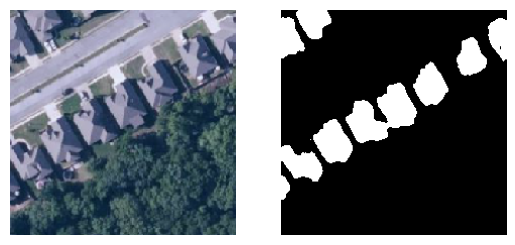

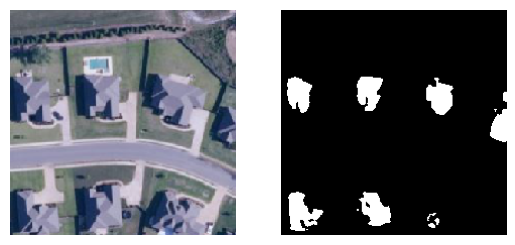

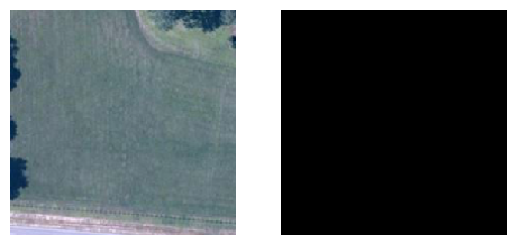

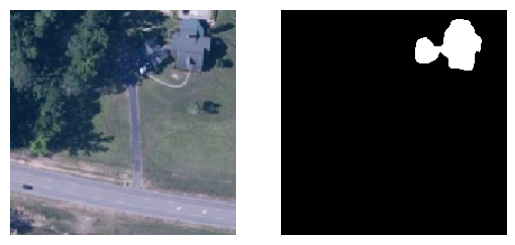

100%|██████████| 447/447 [04:00<00:00,  1.86it/s]


Epoch 2, Loss: 0.08758120004179361


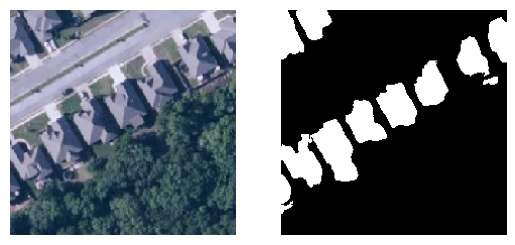

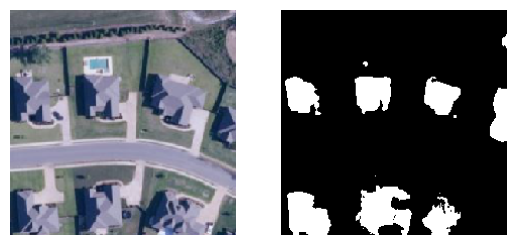

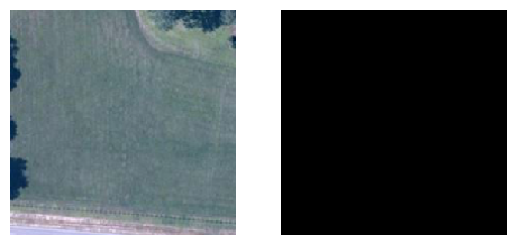

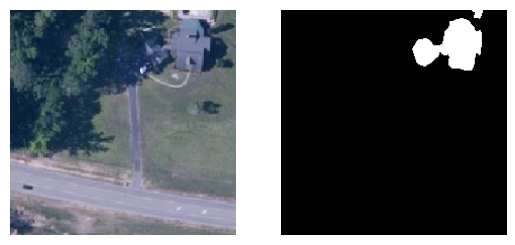

100%|██████████| 447/447 [04:02<00:00,  1.84it/s]


Epoch 3, Loss: 0.08929188966634423


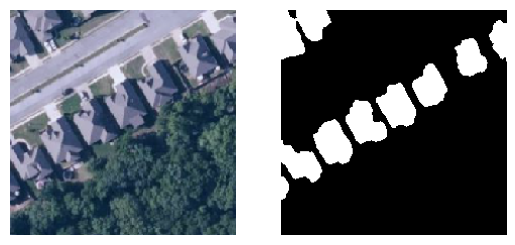

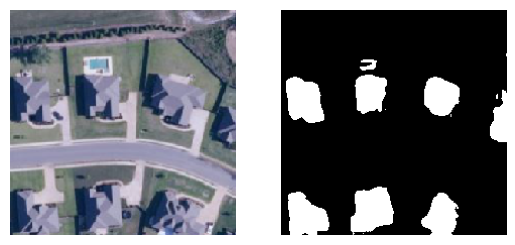

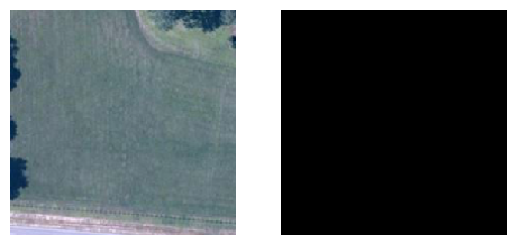

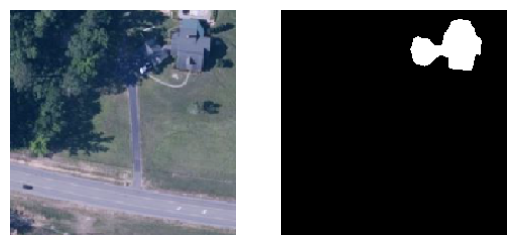

100%|██████████| 447/447 [04:04<00:00,  1.83it/s]


Epoch 4, Loss: 0.08375560651456217


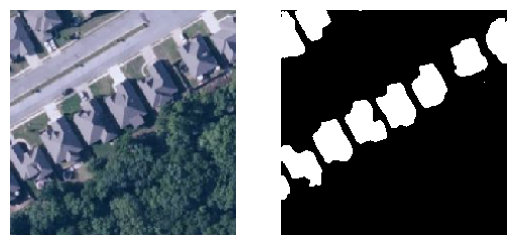

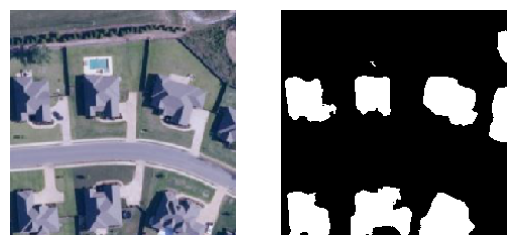

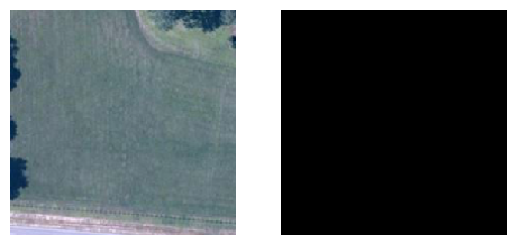

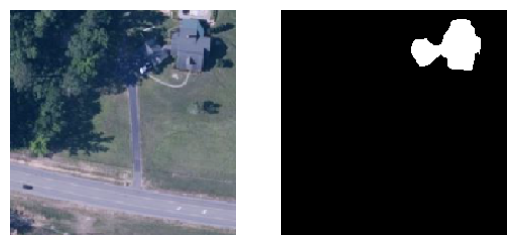

100%|██████████| 447/447 [04:06<00:00,  1.81it/s]


Epoch 5, Loss: 0.08312159628759427


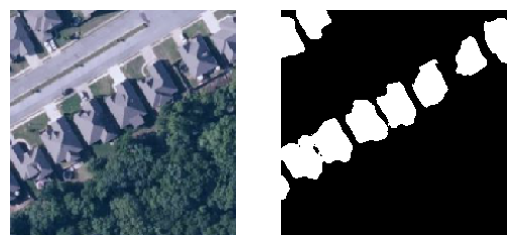

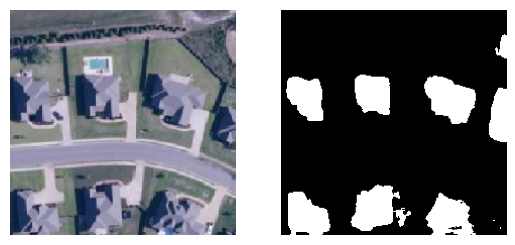

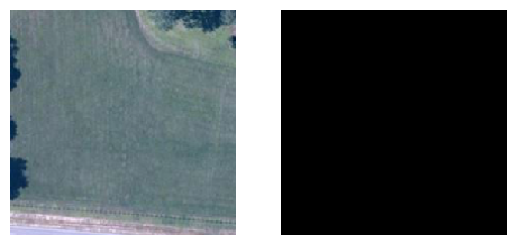

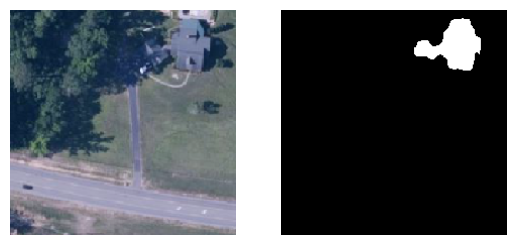

100%|██████████| 447/447 [04:10<00:00,  1.78it/s]


Epoch 6, Loss: 0.08033560644376865


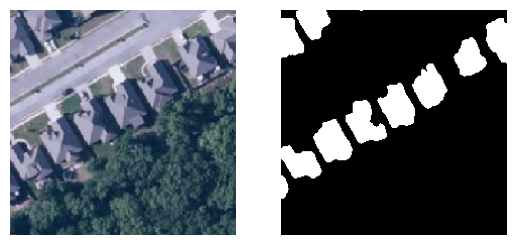

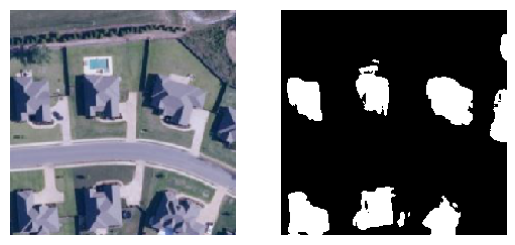

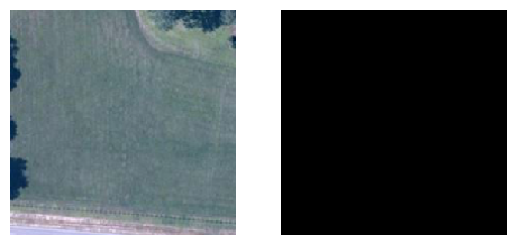

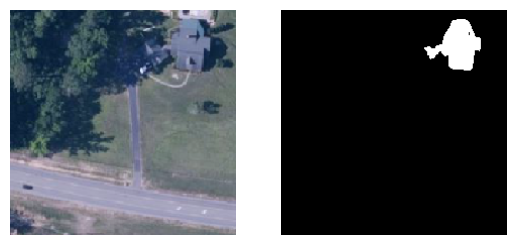

100%|██████████| 447/447 [04:11<00:00,  1.78it/s]


Epoch 7, Loss: 0.08046420700681423


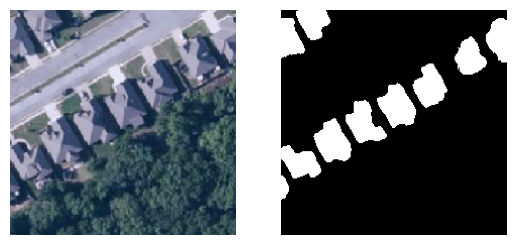

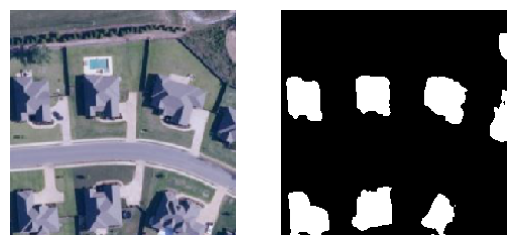

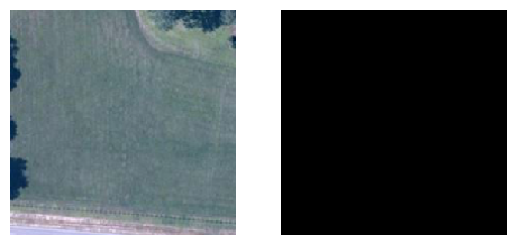

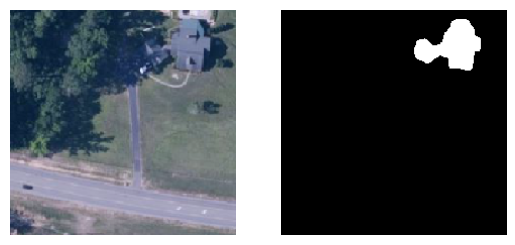

100%|██████████| 447/447 [04:13<00:00,  1.76it/s]


Epoch 8, Loss: 0.09668307670577528


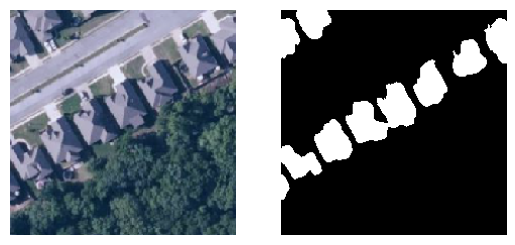

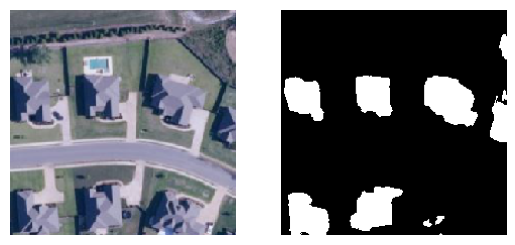

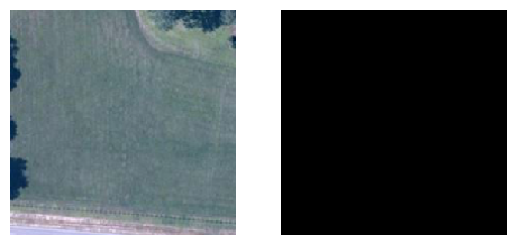

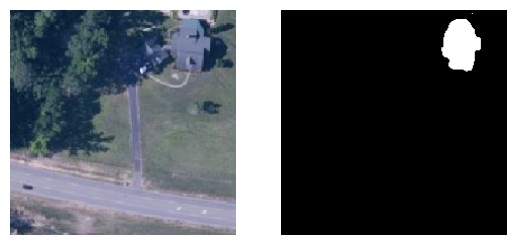

100%|██████████| 447/447 [04:13<00:00,  1.76it/s]


Epoch 9, Loss: 0.08520984780918432


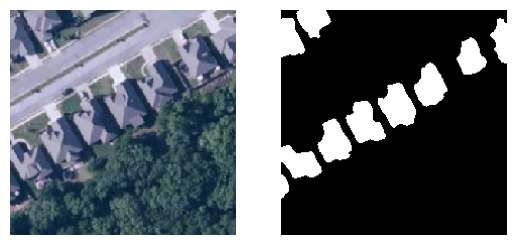

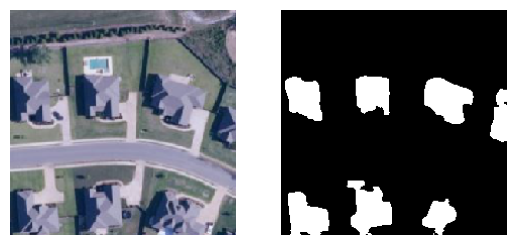

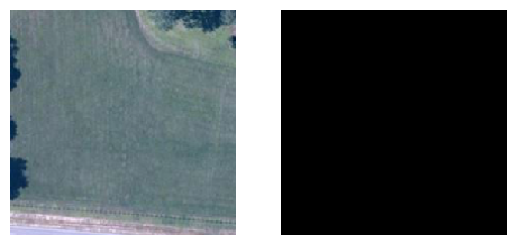

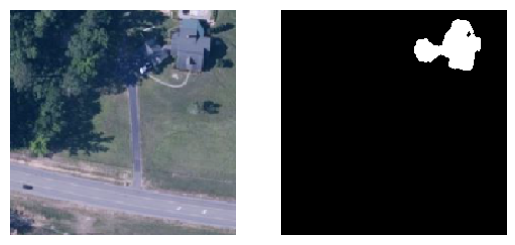

100%|██████████| 447/447 [04:18<00:00,  1.73it/s]


Epoch 10, Loss: 0.0784203945940373


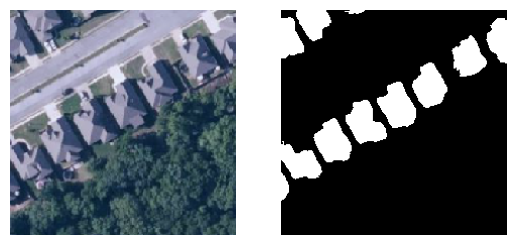

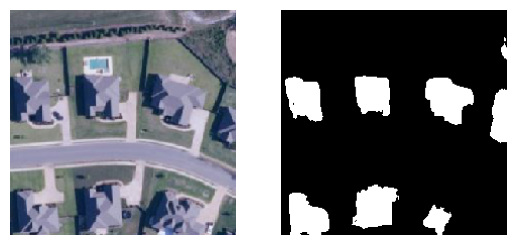

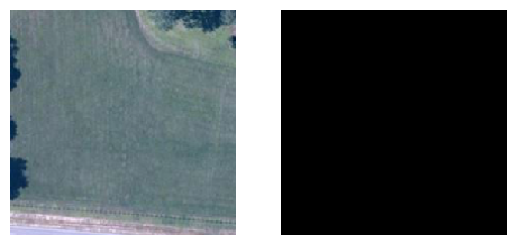

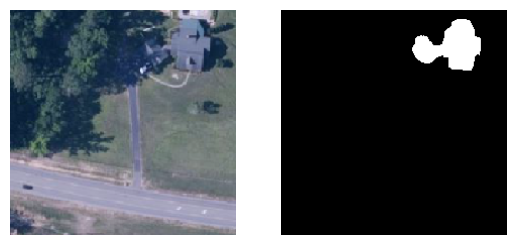

In [ ]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_idx = [3, 5, 7, 9]

# model 초기화
# model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')
    with torch.no_grad():
        model.eval()
        for i in test_idx:
            image = test_dataset[i]
            input_image = image.to(device)
            mask = model(input_image.float().to(device).unsqueeze(0))[0]
            mask = torch.sigmoid(mask).cpu().numpy()
            mask = np.squeeze(mask, axis=0)
            mask = (mask > 0.35).astype(np.uint8) # Threshold = 0.35
            plt.figure()
            plt.subplot(1, 2, 1)
            image = (image - image.min()) / (image.max() - image.min())
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.show()

### Inference

In [ ]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3790/3790 [11:38<00:00,  5.42it/s]


### Submission

In [ ]:
csv_name = 'submit_1_20'

submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

submit.to_csv(f'./{csv_name}.csv', index=False)
files.download(f'./{csv_name}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Save Model

In [ ]:
model_name = 'model_1_20'
torch.save(model, f'./{model_name}.pth')
files.download(f'./{model_name}.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load Model

In [ ]:
model = torch.load('./model_1_10.pth')